In [4]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.ensemble import RandomForestClassifier

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [7]:
def load_data(pkl_path="", csv_path=""):
    if pkl_path != "":
        pkl_file = open(pkl_path, 'rb')
        data = pickle.load(pkl_file)
    elif csv_path != "":
        data = pd.read_csv(csv_path)
    return data    

In [8]:
def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

In [9]:
def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse

In [10]:
def create_site_user_dic(train_data, site_freq_file):
    user_dic = {}
    site_dic = {}

    pkl_file = open(site_freq_file, 'rb')
    site_freq = pickle.load(pkl_file)
    top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]

    for i, v in train_data.iterrows():
        if v.target not in user_dic:
            user_dic[v.target] = {}
        for site in ['site' + str(i) for i in range(1,11)]:
            if v[site] != 0 and v[site] not in top_sites:
                if v[site] in user_dic[v.target]:
                    user_dic[v.target][v[site]] +=1
                else:
                    user_dic[v.target][v[site]] = 1

            if v[site] in site_dic:
                site_dic[v[site]].add(v.target)
            else:
                site_dic[v[site]] = set([v.target])
    
    return [user_dic, site_dic]

In [11]:
def add_predictions(train_data, test_data, site_dic, user_dic, num_users = 1, todict=False):
    dict_pred = [{},{}]
    data_i = 0
    for data in [train_data, test_data]:
        if not dict_pred:
            data["prediction"] = 0
        for r, v in data.iterrows():
            found_definite_pred = False
            session_prediction = []
            for site in ['site' + str(c) for c in range(1,11)]:
                if v[site] in site_dic and len(site_dic[v[site]]) == 1:
                    if not todict:
                        data.set_value(r, -1, list(site_dic[v[site]])[0], takeable=True)
                    dict_pred[data_i][r] = [list(site_dic[v[site]])[0], 1]
                    found_definite_pred = True
                elif v[site] in site_dic and len(site_dic[v[site]]) in range(2, num_users+1):
                    predictions = sorted([[int(user), float(user_dic[user][v[site]]) / sum(user_dic[user].values())] \
                                         for user in site_dic[v[site]] if v[site] in user_dic[user]], \
                                                                       key=lambda t: t[1], reverse=True)
                    if len(predictions):
                        session_prediction.append(predictions[0])
                if found_definite_pred:
                    break
                        
            if found_definite_pred == False and len(session_prediction):
                if not todict:
                    if v["prediction"] == 0:
                        prediction = sorted(session_prediction, key=lambda t: t[1], reverse=True)[0][0]
                        data.set_value(r, -1, prediction, takeable=True)
                else:
                    session_users = zip(*session_prediction)[0]
                    user_counter = Counter(session_users)
                    dict_pred[data_i][r] = [list(sorted(user_counter.items(), key=lambda srt: srt[1], reverse=True))[0][0],\
                                    list(sorted(user_counter.items(), key=lambda srt: srt[1], reverse=True))[0][1]/ \
                                    float(sum(user_counter.values()))]
        data_i+=1
        
    if not todict:
        return [train_data, test_data]
    else:
        return dict_pred

In [12]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]

In [13]:
def sites_to_sparse(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,session_length+1)]].fillna(0).astype('int')
    X_train_test_sparse = sparsematrix(train_test_df_sites.as_matrix())
    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    y = train_data[target_col]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder]

In [14]:
def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix

In [15]:
def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse):
    X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
    X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
    return [X_train_sparse, X_test_sparse]

In [16]:
from string import ascii_lowercase

In [17]:
def sparse_matrix_to_vw(X_sparse, sites_columns_num, y=None):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):        
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                continue
            elif c == X_sparse.shape[1] - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                continue
            if c < sites_columns_num:
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                else:
                    if y is not None:
                        sessions[r] = str(y[r]) + ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
                    else:
                        sessions[r] = ' |site' + " {}:{}".format(int(c+1), int(X_sparse[r,c]))
            elif c > X_sparse.shape[1] - sites_columns_num:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes}

In [18]:
def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites", "session_timespan"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()

In [19]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Let's check if creating sessions with windows [5, 7] improves accuracy**

In [20]:
# Loading processed train and test files
train_data = load_data(csv_path='kaggle_data/full_train_w5_new.csv')
test_data = load_data(csv_path='kaggle_data/full_test.csv')

In [21]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
#site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [22]:
# Convert site times to sparse format
#site_times_sparse = site_times_to_sparse(site_times)
#train_site_times_sparse = site_times_sparse[:len(train_data)]
#test_site_times_sparse = site_times_sparse[len(train_data):]
#site_times_sparse

In [23]:
%%time
#Generate only once per kernel launch
#user_dic, site_dic = create_site_user_dic(train_data, site_freq_file="kaggle_data/site_freq.pkl")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [24]:
%%time
#Predictions no longer needed since they are already included in train and test data!
#train_data, test_data = add_predictions(train_data, test_data, site_dic, user_dic, num_users = 1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [25]:
total_filled = len(train_data[train_data.prediction != 0]) / float(len(train_data))
right_filled = sum([int(int(a) == int(b)) for a, b in \
                                    zip(train_data["target"], train_data["prediction"])]) / float(len(train_data))
print "total_filled:", total_filled
print "right_filled", right_filled
print right_filled/total_filled

total_filled: 0.211788304994
right_filled 0.211788304994
1.0


In [26]:
%%time
X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder = \
    sites_to_sparse(train_data, test_data, "target", 10, label_encoder=LabelEncoder())
    
mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)



X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             X_test_sparse, \
                                                              test_features)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

Sparse Matrix - rows: 212669 columns: 24053
CPU times: user 5.03 s, sys: 676 ms, total: 5.7 s
Wall time: 5.71 s


In [43]:
with open('kaggle_data/vw/train_part_sparse_w5.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('kaggle_data/vw/valid_sparse_w5.pkl', 'wb') as f:
    pickle.dump(X_valid, f)
with open('kaggle_data/vw/train_sparse_w5.pkl', 'wb') as f:
    pickle.dump(X_train_sparse, f)
with open('kaggle_data/vw/test_sparse_w5.pkl', 'wb') as f:
    pickle.dump(X_test_sparse, f)
    
y.to_csv("kaggle_data/y_w5.csv", index=False, header=False)
pd.DataFrame(y_train).to_csv("kaggle_data/y_train_w5.csv", index=False, header=False)
pd.DataFrame(y_valid).to_csv("kaggle_data/y_valid_w5.csv", index=False, header=False)

import datetime
print datetime.datetime.now().strftime('Configuration saved on %d, %b %Y - %H:%M')

Configuration saved on 01, Jan 2017 - 03:39


In [20]:
%%time
with open('kaggle_data/vw/train_part_sparse_w5.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('kaggle_data/vw/valid_sparse_w5.pkl', 'rb') as f:
    X_valid = pickle.load(f)
with open('kaggle_data/vw/train_sparse_w5.pkl', 'rb') as f:
    X = pickle.load(f)
with open('kaggle_data/vw/test_sparse_w5.pkl', 'rb') as f:
    X_test = pickle.load(f)
    
y=pd.read_csv("kaggle_data/y_w5.csv", header=None, squeeze=True)
y_train=pd.read_csv("kaggle_data/y_train_w5.csv", header=None, squeeze=True)
y_valid=pd.read_csv("kaggle_data/y_valid_w5.csv", header=None, squeeze=True)

CPU times: user 1.26 s, sys: 128 ms, total: 1.39 s
Wall time: 1.39 s


## RandomForestClassifier

In [27]:
%%time
forest = RandomForestClassifier(n_estimators=20, oob_score=True, n_jobs=2, random_state=7)
forest.fit(X_train, y_train)

/home/dlihhats/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 3min 13s, sys: 20.6 s, total: 3min 34s
Wall time: 1min 55s


In [ ]:
forest.oob_score_

In [ ]:
rf_valid_acc = accuracy_score(forest.predict(X_valid), y_valid)
rf_valid_acc

In [ ]:
%%time
train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, y_train)
valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, y_for_vw)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num)

In [139]:
X_train.shape[0]

119546

In [ ]:
for k in train_part_vw.keys():
    print k, len(train_part_vw[k])

In [140]:
for k in train_part_vw.keys():
    print k, len(train_part_vw[k])

youtube_portion 4992
site_longest_time 119546
top30_portion 71543
sitetimes 115811
unique_site 119546
start_hour 119546
prediction 21029
session_timespan 114607
day_of_week 119546
bot30_portion 35735
fb_portion 10550
sites 119546
daytime 119546


In [141]:
with open('kaggle_data/vw/train_part_vw_w5.pkl', 'wb') as f:
    pickle.dump(train_part_vw, f)
with open('kaggle_data/vw/valid_vw_w5.pkl', 'wb') as f:
    pickle.dump(valid_vw, f)
with open('kaggle_data/vw/train_vw_w5.pkl', 'wb') as f:
    pickle.dump(train_vw, f)
with open('kaggle_data/vw/test_vw_w5.pkl', 'wb') as f:
    pickle.dump(test_vw, f)
with open('kaggle_data/vw/class_encoder_w5.pkl', 'wb') as f:
    pickle.dump(class_encoder, f)
    
y.to_csv("kaggle_data/y_w5.csv", index=False, header=False)
pd.DataFrame(y_train).to_csv("kaggle_data/y_train_w5.csv", index=False, header=False)
pd.DataFrame(y_valid).to_csv("kaggle_data/y_valid_w5.csv", index=False, header=False)

import datetime
datetime.datetime.now()

In [36]:
import pickle

with open('kaggle_data/vw/train_part_vw_w5.pkl', 'rb') as f:
    train_part_vw = pickle.load(f)
with open('kaggle_data/vw/valid_vw_w5.pkl', 'rb') as f:
    valid_vw = pickle.load(f)
with open('kaggle_data/vw/train_vw_w5.pkl', 'rb') as f:
    train_vw = pickle.load(f)
with open('kaggle_data/vw/test_vw_w5.pkl', 'rb') as f:
    test_vw = pickle.load(f)
with open('kaggle_data/vw/class_encoder_w5.pkl', 'rb') as f:
    class_encoder = pickle.load(f)
y=pd.read_csv("kaggle_data/y_w5.csv", header=None, squeeze=True)
y_train=pd.read_csv("kaggle_data/y_train_w5.csv", header=None, squeeze=True)
y_valid=pd.read_csv("kaggle_data/y_valid_w5.csv", header=None, squeeze=True)

In [37]:
keys = [
   'day_of_week',
   'daytime',
   'prediction',
   'start_hour',
   'youtube_portion', 'fb_portion']

vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part_w5.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
vw_to_file(valid_vw["sites"], 'kaggle_data/valid_w5.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], 'kaggle_data/train_w5.vw', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], 'kaggle_data/test_w5.vw', features={x:test_vw[x] for x in keys}, quiet=False)


Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [47]:
with open("kaggle_data/train_part_w5.vw") as f:
    train_part_file = f.readlines()

with open("kaggle_data/train_w5.vw") as f:
    train_file = f.readlines()

with open("kaggle_data/valid_w5.vw") as f:
    valid_file = f.readlines()

with open("kaggle_data/test_w5.vw") as f:
    test_file = f.readlines()

In [48]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [46]:
%%time
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, decay_learning_rate=0.8097261737051064, \
           initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='logistic', l1=1.2144958188964683e-11, cubic="bcd", sort_features=True, q="bs cs")

c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=-1)
print c_scores, np.mean(c_scores)

Process PoolWorker-132:
Process PoolWorker-134:
Process PoolWorker-135:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-136:
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dlihhats/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
Process PoolWorker-133:
    task = get()
    self.run()
  File "/home/dlihhats/anaconda

KeyboardInterrupt: 

In [146]:
%%time
#model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, loss_function='squared', random_seed=7)
model.fit(train_part_file)
print accuracy_score(y_valid, model.predict(valid_file))

0.533912364595
CPU times: user 12min 30s, sys: 1.66 s, total: 12min 32s
Wall time: 12min 21s


In [546]:
%%time
model.fit(train_file)
test = model.predict(test_file)
submission = pd.DataFrame(test.astype(int)-1)
vw_subm = class_encoder.inverse_transform(submission)
vw_subm

CPU times: user 7min 23s, sys: 1.23 s, total: 7min 25s
Wall time: 7min 19s


In [547]:
print accuracy_score(y_valid, model.predict(valid_file))

0.66049382716


In [548]:
write_to_submission_file(vw_subm,
                         'kaggle_data/10vw_submission.csv')

### Hyperopt

In [ ]:
def run_vw(y_valid, params):
    !vw --oaa=550 -d kaggle_data/train_part_w5.vw --passes=100 \
    -f kaggle_data/initial_model_w5.vw -b 26 --random_seed=7 -c -k \
    --decay_learning_rate 0.8097261737051064 \
    --initial_t 4.617634843743026e-05 -l 0.9037695975303308 --power_t 0.5 --l2=3.022731250666471e-11 \
    --loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="bcd" --sort_features -q "bs" --stage_poly --quiet
    
    !vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
    -p kaggle_data/vw_valid_pred_w5.csv --random_seed=7 --quiet
    
    vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
    accuracy = accuracy_score(y_valid, vw_valid_pred.values)
    
    return accuracy

In [ ]:
%%time
y = y_train
y_v = y_valid
def hyperopt_train_test(params):
    
    with open("kaggle_data/train_part_w5.vw") as f:
        train_part_file = f.readlines()
        
    with open("kaggle_data/valid_w5.vw") as f:
        valid_file = f.readlines()
    
    skf = StratifiedKFold(n_splits=2, shuffle=True)

    t = params['type']
    del params['type']
    if t == 'polynomial_regression':
        model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, sort_features=True, **params)
        return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=-1).mean()
    elif t == 'stage_poly':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y).mean()

    

space = hp.choice('classifier_type', [
    {
        'type': 'polynomial_regression',
        'l': hp.loguniform('l', -10, 1),
        'initial_t': hp.loguniform('initial_t', -10, 0),
        'power_t': hp.choice('power_t', [0.5, 1]),
        'decay_learning_rate': hp.uniform('decay_learning_rate', 0.75, 1),
        'l2': hp.uniform('l2', 1e-20, 1e-10),
        'l1': hp.uniform('l1', 1e-20, 1e-10),
        'loss_function': hp.choice('loss_function', ["squared", "hinge", "logistic"]),
        'cubic': hp.choice('cubic', ['bcd', 'sbc', 'sdb', 'sdb bcd']),
        'q': hp.choice('q', ['bd', 'bc', 'bs' 'bs cs', 'ss bs cs'])
    },
    {
        'type': 'bfgs',
        
    }
])


def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=200, trials=trials)
print 'best:'
print best

#### Single model

In [ ]:
%%time
def hyperopt_train_test(params):
    with open("kaggle_data/train_part_w5.vw") as f:
        train_part_file = f.readlines()
    
    model = VW(oaa=550, passes=50, b=26, convert_to_vw=False, sort_features=True, **params)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=-1).mean()

space4knn = {
    'l': hp.loguniform('l', -1, 1),
    'initial_t': hp.loguniform('initial_t', -10, -5),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.75, 1),
    'l2': hp.uniform('l2', 1e-20, 1e-10),
    'l1': hp.uniform('l1', 1e-20, 1e-10),
    'loss_function': hp.choice('loss_function', ["squared", "hinge", "logistic"]),
    'cubic': hp.choice('cubic', ['bcd', 'sbc', 'sdb']),
    #'q': hp.choice('q1', ["bd", "bc", "bs", "bs cs", "ss bs", "sd bc"])
    'q': hp.choice('q2', ["bd", "bc", "bs", "cs", "ss", "sd"])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=200, trials=trials)
print 'best:'
print best

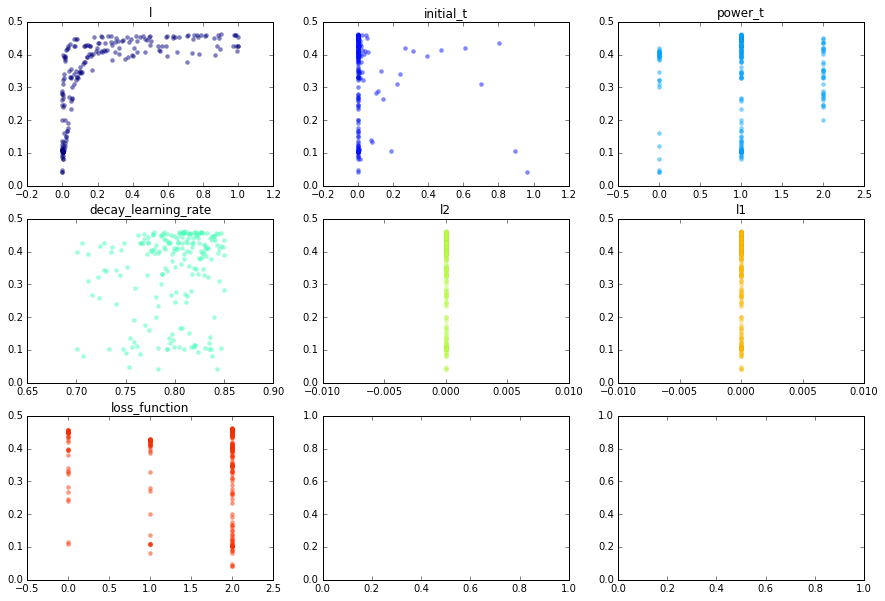

In [448]:
parameters = ['l', 'initial_t', 'power_t', 'decay_learning_rate', 'l2', 'l1', 'loss_function']
cols = len(parameters)
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    #print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])

**shell VW**

In [151]:
%%time

def run_poly(y_valid):
    !vw --oaa=550 -d kaggle_data/train_part_w5.vw --passes=100 \
    -f kaggle_data/initial_model_w5.vw -b 26 --random_seed=7 --cache_file kaggle_data/w5_cache.vw -k \
    --decay_learning_rate 0.8097261737051064 \
    --initial_t 4.617634843743026e-05 -l 0.9037695975303308 --power_t 0.5 --l2=3.022731250666471e-11 \
    --loss_function='logistic' --l1=1.2144958188964683e-11 --cubic="bcd" --sort_features -q "bs" --stage_poly --quiet
    
    !vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
    -p kaggle_data/vw_valid_pred_w5.csv --random_seed=7 --quiet
    
    vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
    accuracy = accuracy_score(y_valid, vw_valid_pred.values)
    
    return accuracy

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [152]:
accuracy = run_poly(y_valid)
print "Accuracy on Poly:", accuracy

Accuracy on Poly: 0.494720405972


In [577]:
%%time
!vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
-p kaggle_data/vw_valid_pred_w5.csv --random_seed=7

creating quadratic features for pairs: bs 
creating cubic features for triples: bcd 
only testing
predictions = kaggle_data/vw_valid_pred_w5.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/valid_w5.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       54      145       17
1.000000 1.000000            2            2.0       97      156       19
1.000000 1.000000            4            4.0      442      189       15
0.875000 0.750000            8            8.0      168      351       15
0.687500 0.500000           16           16.0      508      214       15
0.562500 0.437500           32           32.0      223      223       13
0.562500 0.562500           64           64.0      131      330        9
0.515625 0.468750          128          128.0       34 

In [578]:
vw_valid_pred = pd.read_csv("kaggle_data/vw_valid_pred_w5.csv", header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.51428518145537283

In [261]:
trainvw = open("kaggle_data/train_w5.vw").readlines()
np.random.shuffle(trainvw)
with open("kaggle_data/train_w5.vw", "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [262]:
%%time
!vw --oaa=550 -d kaggle_data/train_w5.vw --passes=10 \
-f kaggle_data/initial_model_w5.vw -b 26 --random_seed=7 --cache_file kaggle_data/w5_cache.vw -k

final_regressor = kaggle_data/initial_model_w5.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/w5_cache.vw
Reading datafile = kaggle_data/train_w5.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      444        1        9
1.000000 1.000000            2            2.0       18      444        8
1.000000 1.000000            4            4.0      473      444       12
1.000000 1.000000            8            8.0      474      154        6
1.000000 1.000000           16           16.0      115      154        7
1.000000 1.000000           32           32.0      487      273        7
0.984375 0.968750           64           64.0       86      186       11
0.976562 0.968750          128          128.0      311      517       10
0.945312 0.914062     

In [263]:
%%time
!vw -i kaggle_data/initial_model_w5.vw -t -d kaggle_data/valid_w5.vw \
-p kaggle_data/vw_test_pred_w5.csv --random_seed=7 --quiet

CPU times: user 24 ms, sys: 36 ms, total: 60 ms
Wall time: 1.41 s


In [264]:
vw_pred = pd.read_csv("kaggle_data/vw_test_pred_w5.csv", header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)
vw_subm

array([['174'],
       ['783'],
       ['2336'],
       ..., 
       ['1413'],
       ['1771'],
       ['1845']], dtype=object)

**Let's build pemutations of different features and test the model!**

In [229]:
features = ['bot30_portion',
 'day_of_week',
 'daytime',
 'fb_portion',
 'prediction',
 'session_timespan',
 'start_hour',
 'top30_portion', 'youtube_portion']
features

['bot30_portion',
 'day_of_week',
 'daytime',
 'fb_portion',
 'prediction',
 'session_timespan',
 'start_hour',
 'top30_portion',
 'youtube_portion']

In [230]:
%%time

results = {}

for L in range(5, 9):#len(features)+1):
    for subset in itertools.combinations(features, L):      
        keys = list(subset)
        print "Features:", keys

        vw_to_file(train_part_vw["sites"], 'kaggle_data/train_part_w5.vw', features={x:train_part_vw[x] for x in keys})
        vw_to_file(valid_vw["sites"], 'kaggle_data/valid_w5.vw', features={x:valid_vw[x] for x in keys})
        vw_to_file(train_vw["sites"], 'kaggle_data/train_w5.vw', features={x:train_vw[x] for x in keys})
        vw_to_file(test_vw["sites"], 'kaggle_data/test_w5.vw', features={x:test_vw[x] for x in keys})
        
        f = open("kaggle_data/train_part_w5.vw")
        X_train = f.readlines()
        f.close()

        f = open("kaggle_data/valid_w5.vw")
        X_valid = f.readlines()
        f.close()
        
        model = VW(oaa=550, passes=10, b=26, convert_to_vw=False, loss_function='squared')
        cross_scores = cross_val_score(model, X=X_train, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), \
                                                                                                      n_jobs=-1)
        model.fit(X_train)
        accuracy = accuracy_score(y_valid, model.predict(X_valid))
        if np.mean(cross_scores) > 0.45:
            print "POTENTIAL WINNER!"
        print "CV score:", np.mean(cross_scores), "Valid score:", accuracy, "\n"
        results[tuple(keys) or "sites_only"] = {"CV": np.mean(cross_scores), "valid": accuracy}

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'prediction']
CV score: 0.428249403455 Valid score: 0.43513856253 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'session_timespan']
CV score: 0.402299384357 Valid score: 0.414549998135 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'start_hour']
CV score: 0.432272901038 Valid score: 0.443586587595 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'top30_portion']
CV score: 0.401995487292 Valid score: 0.414177016896 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'fb_portion', 'youtube_portion']
CV score: 0.401379425838 Valid score: 0.41430756033 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'prediction', 'session_timespan']
CV score: 0.429592100559 Valid score: 0.436425347805 

Features: ['bot30_portion', 'day_of_week', 'daytime', 'prediction', 'start_hour']
POTENTIAL WINNER!
CV score: 0.458891248881 Valid score: 0.465760322256 

Featu

In [231]:
sorted(results.items(), key=lambda t: t[1]["CV"], reverse=True)[0:5]

[(('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45998619175968986, 'valid': 0.46714035284025213}),
 (('day_of_week',
   'daytime',
   'fb_portion',
   'prediction',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45990670132196049, 'valid': 0.46576032225579056}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45966497130778228, 'valid': 0.46626384692849948}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45960830714374462, 'valid': 0.4676438775129611}),
 (('day_of_week',
   'daytime',
   'fb_portion',
   'prediction',
   'start_hour',
   'youtube_portion'),
  {'CV': 0.45947824810382548, 'valid': 0.46618925068069078})]

In [232]:
sorted(results.items(), key=lambda t: t[1]["valid"], reverse=True)[0:5]

[(('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45960830714374462, 'valid': 0.4676438775129611}),
 (('bot30_portion',
   'day_of_week',
   'daytime',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45998619175968986, 'valid': 0.46714035284025213}),
 (('day_of_week',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.45826827578467516, 'valid': 0.46687926597292156}),
 (('bot30_portion',
   'day_of_week',
   'fb_portion',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion',
   'youtube_portion'),
  {'CV': 0.45858398130710709, 'valid': 0.46671142441535191}),
 (('bot30_portion',
   'day_of_week',
   'fb_portion',
   'prediction',
   'session_timespan',
   'start_hour',
   'top30_portion'),
  {'CV': 0.4577515233046956, 'valid': 0.466618179105591})]